In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import copy
from tqdm import tqdm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Dataset path
DATASET_ROOT = r"D:\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Dataset"
TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VALID_DIR = os.path.join(DATASET_ROOT, "valid")

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES = 4
CLASS_NAMES = ['amd', 'cataract', 'diabetes', 'normal']

print(f"Train directory: {TRAIN_DIR}")
print(f"Valid directory: {VALID_DIR}")

Train directory: D:\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Dataset\train
Valid directory: D:\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Dataset\valid


In [3]:
class AMDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}
        
        for class_name in CLASS_NAMES:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])
        
        print(f"Loaded {len(self.images)} images from {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = AMDDataset(TRAIN_DIR, transform=train_transform)
val_dataset = AMDDataset(VALID_DIR, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loaded 1594 images from D:\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Dataset\train
Loaded 400 images from D:\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\AMDNet23 Dataset\valid

Training samples: 1594
Validation samples: 400


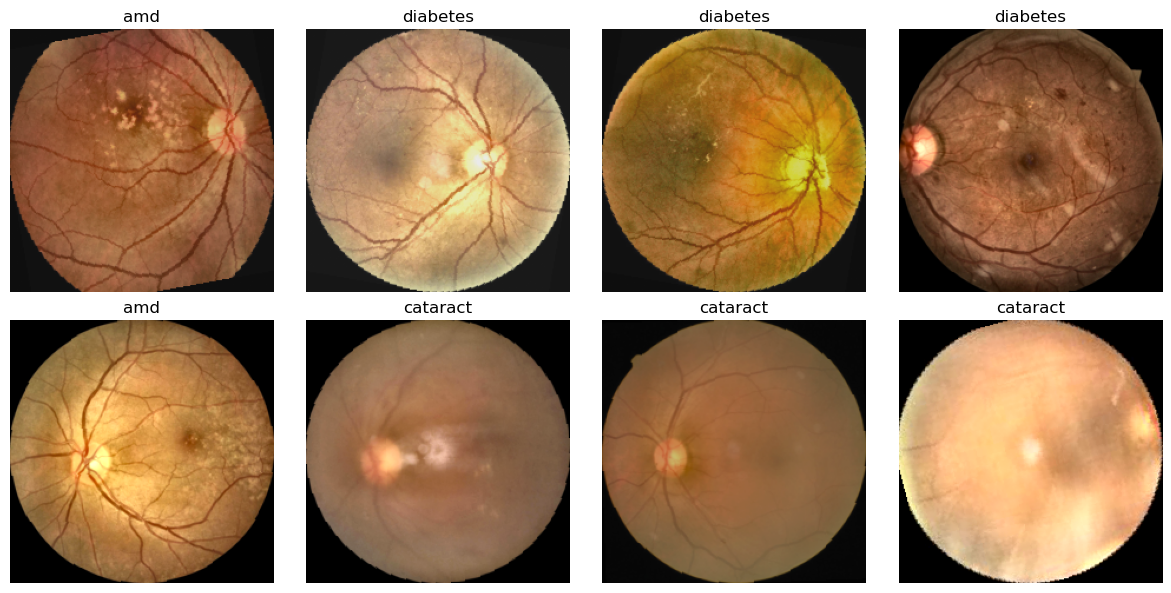

In [5]:
# Get a batch of images
images, labels = next(iter(train_loader))

# Denormalize for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[labels[i]])
        ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the final layer for our classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 24,559,172
Trainable parameters: 24,559,172


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [8]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / total, correct / total, all_preds, all_labels

In [9]:
# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0
best_model_wts = None

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"✓ New best model saved! Accuracy: {val_acc:.4f}")
    
    print()

print(f"Training complete! Best validation accuracy: {best_acc:.4f}")

Starting training...

Epoch 1/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:44<00:00,  3.39s/it]


Train Loss: 0.6482 | Train Acc: 0.7484
Val Loss: 0.2131 | Val Acc: 0.9175
✓ New best model saved! Accuracy: 0.9175

Epoch 2/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:46<00:00,  3.59s/it]


Train Loss: 0.2657 | Train Acc: 0.9034
Val Loss: 0.1224 | Val Acc: 0.9525
✓ New best model saved! Accuracy: 0.9525

Epoch 3/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.84s/it]


Train Loss: 0.1935 | Train Acc: 0.9329
Val Loss: 0.2438 | Val Acc: 0.8975

Epoch 4/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:38<00:00,  3.00s/it]


Train Loss: 0.1679 | Train Acc: 0.9404
Val Loss: 0.1311 | Val Acc: 0.9525

Epoch 5/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.05s/it]


Train Loss: 0.1736 | Train Acc: 0.9435
Val Loss: 0.1028 | Val Acc: 0.9600
✓ New best model saved! Accuracy: 0.9600

Epoch 6/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.87s/it]


Train Loss: 0.1178 | Train Acc: 0.9580
Val Loss: 0.0955 | Val Acc: 0.9525

Epoch 7/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.89s/it]


Train Loss: 0.1469 | Train Acc: 0.9504
Val Loss: 0.0844 | Val Acc: 0.9675
✓ New best model saved! Accuracy: 0.9675

Epoch 8/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.07s/it]


Train Loss: 0.1303 | Train Acc: 0.9573
Val Loss: 0.0869 | Val Acc: 0.9675

Epoch 9/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.83s/it]


Train Loss: 0.0919 | Train Acc: 0.9718
Val Loss: 0.0871 | Val Acc: 0.9725
✓ New best model saved! Accuracy: 0.9725

Epoch 10/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.25s/it]


Train Loss: 0.0700 | Train Acc: 0.9749
Val Loss: 0.1405 | Val Acc: 0.9600

Epoch 11/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.13s/it]


Train Loss: 0.0684 | Train Acc: 0.9755
Val Loss: 0.0788 | Val Acc: 0.9775
✓ New best model saved! Accuracy: 0.9775

Epoch 12/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.90s/it]


Train Loss: 0.0818 | Train Acc: 0.9730
Val Loss: 0.0914 | Val Acc: 0.9750

Epoch 13/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.89s/it]


Train Loss: 0.0885 | Train Acc: 0.9724
Val Loss: 0.2536 | Val Acc: 0.9400

Epoch 14/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.86s/it]


Train Loss: 0.0815 | Train Acc: 0.9711
Val Loss: 0.0900 | Val Acc: 0.9650

Epoch 15/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.82s/it]


Train Loss: 0.0600 | Train Acc: 0.9831
Val Loss: 0.0831 | Val Acc: 0.9775

Epoch 16/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.81s/it]


Train Loss: 0.0349 | Train Acc: 0.9881
Val Loss: 0.0775 | Val Acc: 0.9675

Epoch 17/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.87s/it]


Train Loss: 0.0408 | Train Acc: 0.9887
Val Loss: 0.1032 | Val Acc: 0.9675

Epoch 18/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.82s/it]


Train Loss: 0.0275 | Train Acc: 0.9918
Val Loss: 0.0778 | Val Acc: 0.9775

Epoch 19/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.80s/it]


Train Loss: 0.0197 | Train Acc: 0.9950
Val Loss: 0.0820 | Val Acc: 0.9725

Epoch 20/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:38<00:00,  2.93s/it]


Train Loss: 0.0226 | Train Acc: 0.9937
Val Loss: 0.1238 | Val Acc: 0.9625

Epoch 21/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.91s/it]


Train Loss: 0.0213 | Train Acc: 0.9937
Val Loss: 0.0968 | Val Acc: 0.9700

Epoch 22/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [01:05<00:00,  5.02s/it]


Train Loss: 0.0117 | Train Acc: 0.9962
Val Loss: 0.0918 | Val Acc: 0.9750

Epoch 23/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:45<00:00,  3.47s/it]


Train Loss: 0.0123 | Train Acc: 0.9969
Val Loss: 0.0976 | Val Acc: 0.9650

Epoch 24/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.05s/it]


Train Loss: 0.0136 | Train Acc: 0.9975
Val Loss: 0.0823 | Val Acc: 0.9750

Epoch 25/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.16s/it]


Train Loss: 0.0085 | Train Acc: 0.9981
Val Loss: 0.0794 | Val Acc: 0.9800
✓ New best model saved! Accuracy: 0.9800

Epoch 26/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]


Train Loss: 0.0038 | Train Acc: 0.9994
Val Loss: 0.0790 | Val Acc: 0.9825
✓ New best model saved! Accuracy: 0.9825

Epoch 27/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:37<00:00,  2.89s/it]


Train Loss: 0.0081 | Train Acc: 0.9994
Val Loss: 0.0737 | Val Acc: 0.9725

Epoch 28/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:38<00:00,  2.96s/it]


Train Loss: 0.0056 | Train Acc: 0.9987
Val Loss: 0.0788 | Val Acc: 0.9725

Epoch 29/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:57<00:00,  4.40s/it]


Train Loss: 0.0066 | Train Acc: 0.9981
Val Loss: 0.0807 | Val Acc: 0.9800

Epoch 30/30
----------------------------------------


Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.20s/it]

Train Loss: 0.0093 | Train Acc: 0.9975
Val Loss: 0.0659 | Val Acc: 0.9775

Training complete! Best validation accuracy: 0.9825


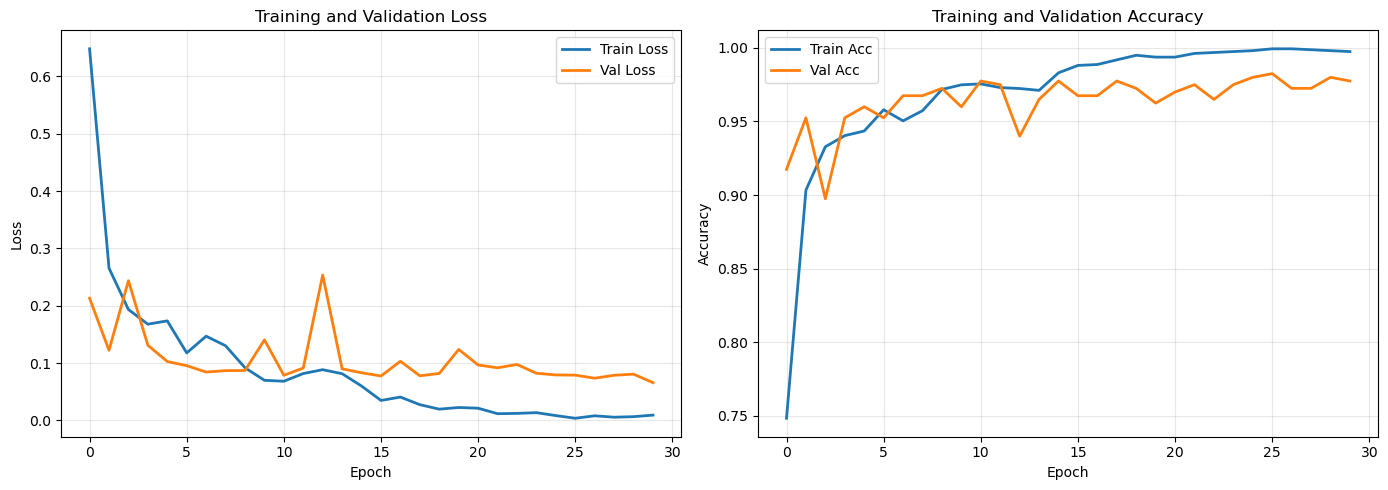

In [11]:
 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Load best model
model.load_state_dict(best_model_wts)

# Final evaluation
val_loss, val_acc, all_preds, all_labels = validate(model, val_loader, criterion)

print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

Validating: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:38<00:00,  2.96s/it]


Final Validation Accuracy: 0.9825
Final Validation Loss: 0.0790

Classification Report:
              precision    recall  f1-score   support

         amd       0.97      1.00      0.99       100
    cataract       1.00      1.00      1.00       100
    diabetes       0.97      0.97      0.97       100
      normal       0.99      0.96      0.97       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [14]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display in classic table format with TP, FP, TN, FN for each class
print("=" * 80)
print("CONFUSION MATRIX - Classic Format")
print("=" * 80)

for i, class_name in enumerate(CLASS_NAMES):
    # For each class as positive:
    # TP: predicted as class i AND actually is class i
    TP = cm[i, i]
    
    # FN: predicted as other classes BUT actually is class i
    FN = cm[i, :].sum() - TP
    
    # FP: predicted as class i BUT actually is other classes
    FP = cm[:, i].sum() - TP
    
    # TN: predicted as other classes AND actually is other classes
    TN = cm.sum() - TP - FN - FP
    
    print(f"\nClass: {class_name.upper()}")
    print("-" * 80)
    print(f"{'':20} | {'Predicted Positive':20} | {'Predicted Negative':20}")
    print("-" * 80)
    print(f"{'Actual Positive':20} | {'TP: ' + str(TP):20} | {'FN: ' + str(FN):20}")
    print(f"{'Actual Negative':20} | {'FP: ' + str(FP):20} | {'TN: ' + str(TN):20}")
    print("-" * 80)
    
    # Calculate metrics for this class
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

print("\n" + "=" * 80)

CONFUSION MATRIX - Classic Format

Class: AMD
--------------------------------------------------------------------------------
                     | Predicted Positive   | Predicted Negative  
--------------------------------------------------------------------------------
Actual Positive      | TP: 100              | FN: 0               
Actual Negative      | FP: 3                | TN: 297             
--------------------------------------------------------------------------------
Precision: 0.9709 | Recall: 1.0000 | F1-Score: 0.9852

Class: CATARACT
--------------------------------------------------------------------------------
                     | Predicted Positive   | Predicted Negative  
--------------------------------------------------------------------------------
Actual Positive      | TP: 100              | FN: 0               
Actual Negative      | FP: 0                | TN: 300             
----------------------------------------------------------------------------

In [15]:
# Create output directory
os.makedirs('outputs/models', exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': CLASS_NAMES,
    'val_acc': best_acc
}, 'outputs/models/amd_model.pth')

print("Model saved to outputs/models/amd_model.pth")

Model saved to outputs/models/amd_model.pth
